# **Binary classification using neural networks**

Here, we'll be building a logistic regression classifier to recognize cats. we use neural network approach to create this classifier

**Add dataset to your environment**

In [ ]:
from google.colab import files
uploaded = files.upload()

**Import necessary packages**

**1. numpy** - used for scientific computing



**2. matplotlib** - used to plot graphs

**3. h5py** - used to interact with a dataset that is stored in h5 format

**4. scipy** - scientific library, we'll use it for image processing

**5. PIL** - PythonImagingLibrary, for image processing                  

**6. %matplotlib inline** - the output of plotting commands is displayed inline within the frontends like jupyternotebook, directly below the codecell

In [ ]:
import numpy as np                        
import matplotlib.pyplot as plt           
import h5py                               
import scipy                              
from PIL import Image                     
from scipy import ndimage                  

%matplotlib inline                        

**Problem statement** : the given dataset consists of :

*   train_catvnoncat.h5 - a training set of m training images labeled as cat (y=1) or non-cat (y=0)
*   test_catvnoncat.h5 - to test your model, it is also labeled as cat (y=1) or non-cat (y=0)

each image is a 3d matrix with shape (num_px,num_px,3) where 3 is for the 3 channels (RGB). thus each image is a square (height = num_px) & (width = numpx)



We will build a simple image-recognition algorihm that can correctly classify pictures as cat or non-cat.

# **Dataset**

first we will create a function which will load and categorize our dataset

In [ ]:
def load_dataset():

  train_dataset = h5py.File("/content/train_catvnoncat.h5","r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) #features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) #labels

  test_dataset = h5py.File("/content/test_catvnoncat.h5","r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) #features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) #labels

  classes = np.array(test_dataset["list_classes"][:]) #list of classes

  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



now we will use the load_dataset() to retrive all values and put them separately in their respective variables.

In [ ]:
train_set_x_orig,  train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()



We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

In [ ]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

here, in the output dtype='|S7' means that the object is of type string and it's size is 7 (no. of bytes).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the index value and re-run to see other images

y = [1], it's a 'cat' picture


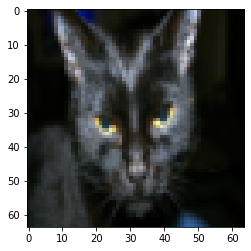

In [ ]:
index = 25
plt.imshow(train_set_x_orig[index])
print("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") + "' picture")

In [ ]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print("Number of training examples : m_train = "+str(m_train))
print("Number of testing examples : m_test = " +str(m_test))
print("height/width of each image : num_px = " + str(num_px))

print("\nEach image is of shape : ( " + str(num_px) + ", "+ str(num_px) + ", 3)\n")

print("train_set_x shape : " + str(train_set_x_orig.shape))
print("train_set_y shape : " + str(train_set_y.shape))
print("test_set_x shape : " + str(test_set_x_orig.shape))
print("test_set_y shape : " + str(test_set_y.shape))

Number of training examples : m_train = 209
Number of testing examples : m_test = 50
height/width of each image : num_px = 64

Each image is of shape : ( 64, 64, 3)

train_set_x shape : (209, 64, 64, 3)
train_set_y shape : (1, 209)
test_set_x shape : (50, 64, 64, 3)
test_set_y shape : (1, 50)


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

In [ ]:
#Reshaping

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))


train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)



To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset.

In [ ]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

**Key steps**: In this exercise, you will carry out the following steps:

- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

## **Building parts for the algorithm**

**sigmoid function**

In [ ]:
def sigmoid(z):
  s = 1/(1+np.exp(-z))
  return s

In [ ]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


**Initializing parameters**

here we have to initialize W as a vector of zeros

This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
Argument:

dim -- size of the w vector we want (or number of parameters in this case)
    
Returns:

w -- initialized vector of shape (dim, 1)

b -- initialized scalar (corresponds to the bias)



In [ ]:
def initialize_with_zeros(dim):
  w = np.zeros(shape=(dim,1))
  b = 0

  assert(w.shape == (dim,1))
  assert(isinstance(b,float) or isinstance(b,int))

  return w, b

In [ ]:
#testing 
dim = 2
w,b = initialize_with_zeros(dim)
print("w = "+str(w))
print("b = "+str(b))

w = [[0.]
 [0.]]
b = 0


# **Forward & Backward propagation**

here we will implement a function propagate() that computes the cost function and its gradient

In [ ]:
def propagate(w, b, X, Y):

  m = X.shape[1]

  #forward prop
  A = sigmoid(np.dot(w.T,X)+b)                              #compute activation
  cost = (-1/m)*np.sum(Y*np.log(A) + (1-Y)*(np.log(1-A)))   #compute cost

  #backward prop
  dw = (1/m)*np.dot(X,(A-Y).T)
  db = (1/m)*np.sum(A-Y)

  assert(dw.shape == w.shape)
  assert(db.dtype == float)

  cost = np.squeeze(cost)

  assert(cost.shape == ())

  grads = {"dw": dw, "db": db}

  return grads, cost

In [ ]:
#testing
w,b,X,Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]]) 

grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


# **Optimization**

 The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):

  costs = []

  for i in range(num_iterations):

    grads, cost = propagate(w,b,X,Y)

    dw = grads["dw"]
    db = grads["db"]

    #update
    w = w - learning_rate * dw
    b = b - learning_rate

    #record the costs
    if i % 100 == 0:
      costs.append(cost)

    #print cost every 100 training examples
    if print_cost and i % 100 == 0:
      print("Cost after iteration %i : %f" % (i, cost))
  
  params = {"w": w,
            "b": b}

  grads = {"dw": dw,
           "db": db}

  return params, grads, costs


In [ ]:
#testing
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.11769657]
 [0.24407619]]
b = 1.1000000000000103
dw = [[0.85749452]
 [1.65598106]]
db = 0.3992432692299293


The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function. There is two steps to computing predictions:

Calculate $\hat{Y} = A = \sigma(w^T X + b)$

Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [ ]:
def predict(w, b, X):
        
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [ ]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.1, print_cost=False):
  
  #initializing parameters
  w,b = initialize_with_zeros(X_train.shape[0])

  #gradient descent
  parameters, grads, costs = optimize(w,b,X_train,Y_train,num_iterations, learning_rate, print_cost)

  #retrieve parameters w & b from dictionary "parameters"
  w = parameters["w"]
  b = parameters["b"]

  #predict test/train set examples
  Y_prediction_test = predict(w,b,X_test)
  Y_prediction_train = predict(w,b,X_train)

  #print train/test errors
  print("train accuracy: {} %".format(100-np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
  print("test accuracy: {} %".format(100-np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

  d = {"costs": costs,
       "Y_prediction_test": Y_prediction_test,
       "Y_prediction_train": Y_prediction_train,
       "w": w,
       "b": b,
       "learning_rate": learning_rate,
       "num_iterations": num_iterations}
  
  return d

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 8000, learning_rate = 0.01, print_cost = True)

Cost after iteration 0 : 0.693147
Cost after iteration 100 : 0.424862
Cost after iteration 200 : 0.464783
Cost after iteration 300 : 0.669042
Cost after iteration 400 : 0.558444
Cost after iteration 500 : 0.409796
Cost after iteration 600 : 0.313547
Cost after iteration 700 : 0.253319
Cost after iteration 800 : 0.219856
Cost after iteration 900 : 0.210097
Cost after iteration 1000 : 0.209126
Cost after iteration 1100 : 0.209227
Cost after iteration 1200 : 0.209769
Cost after iteration 1300 : 0.210614
Cost after iteration 1400 : 0.211684
Cost after iteration 1500 : 0.212926
Cost after iteration 1600 : 0.214302
Cost after iteration 1700 : 0.215783
Cost after iteration 1800 : 0.217350
Cost after iteration 1900 : 0.218984
Cost after iteration 2000 : 0.220674
Cost after iteration 2100 : 0.222409
Cost after iteration 2200 : 0.224180
Cost after iteration 2300 : 0.225982
Cost after iteration 2400 : 0.227809
Cost after iteration 2500 : 0.229656
Cost after iteration 2600 : 0.231521
Cost after it

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


Cost after iteration 7600 : nan
Cost after iteration 7700 : nan
Cost after iteration 7800 : nan
Cost after iteration 7900 : nan
train accuracy: 92.82296650717703 %
test accuracy: 68.0 %


y = 1, you predicted that it is a "non-cat" picture.


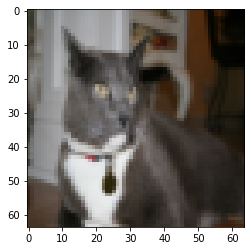

In [ ]:
# Example of a picture that was wrongly classified.
index = 24
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(int(test_set_y[0, index])) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")


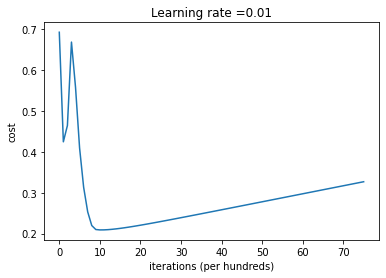

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 93.77990430622009 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 87.5598086124402 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 67.94258373205741 %
test accuracy: 34.0 %

-------------------------------------------------------



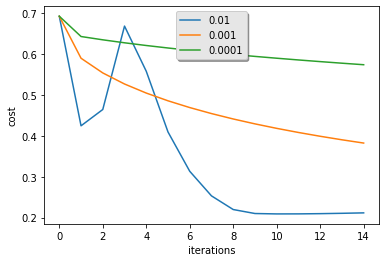

In [ ]:

learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()
